In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F

In [3]:
import os

dir = './data/anime'
print(os.listdir(dir))

['images']


In [4]:
print(os.listdir(dir+'/images')[0:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [6]:
train_ds = ImageFolder(dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [8]:
def denormalization(img_tensor):
    return img_tensor *stats[1][0] +stats[0][0]

In [9]:
def  show_images(images,nmax = 64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denormalization(images.cpu().detach()[:nmax]),nrow=8).permute(1,2,0))
def show_batch(dl,n_max=64):
    for images,_ in dl:
        show_images(images,n_max)
        break



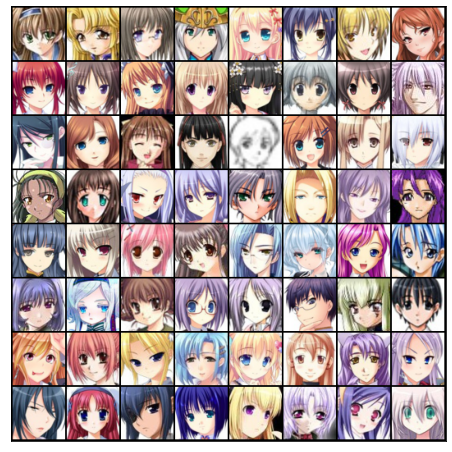

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
device = get_default_device()
device



device(type='cuda')

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


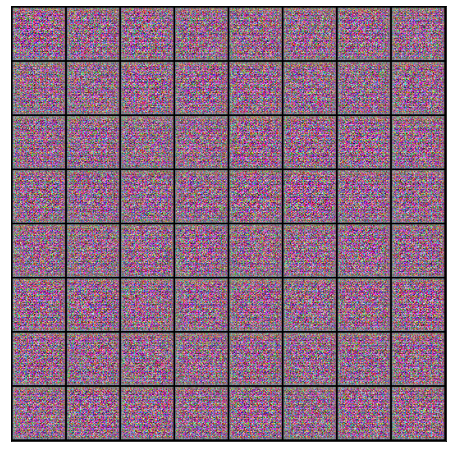

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # clearing discriminator gradient
    opt_d.zero_grad()

    # passing real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # passsing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # updating discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # clearing generator gradients
    opt_g.zero_grad()

    # generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # fooling the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # updationg generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [22]:
from torchvision.utils import save_image
import os

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalization(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [40]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


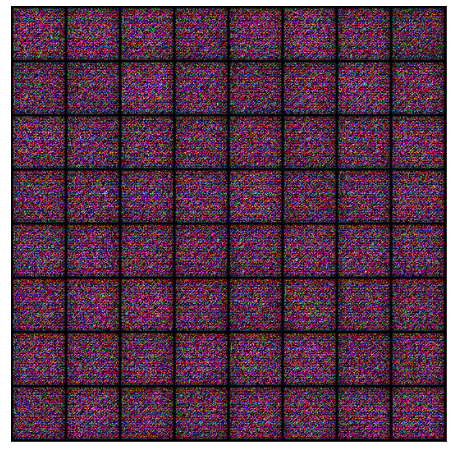

In [26]:
save_samples(0,fixed_latent)

In [272]:
from tqdm.notebook import tqdm

In [275]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            real_images = to_device(real_images,device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # recording losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 25




In [276]:

history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.2358, loss_d: 0.2911, real_score: 0.8252, fake_score: 0.0599
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.3119, loss_d: 0.5190, real_score: 0.8013, fake_score: 0.2043
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 11.0613, loss_d: 0.6101, real_score: 0.9922, fake_score: 0.3889
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 8.8989, loss_d: 0.6613, real_score: 0.9936, fake_score: 0.4136
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.4300, loss_d: 0.1951, real_score: 0.9008, fake_score: 0.0714
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 3.8657, loss_d: 0.2893, real_score: 0.8174, fake_score: 0.0039
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.6444, loss_d: 0.1477, real_score: 0.9190, fake_score: 0.0451
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.6114, loss_d: 0.0971, real_score: 0.9443, fake_score: 0.0344
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.5879, loss_d: 0.1733, real_score: 0.8774, fake_score: 0.0046
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.2963, loss_d: 0.0882, real_score: 0.9451, fake_score: 0.0213
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.3021, loss_d: 0.1475, real_score: 0.9537, fake_score: 0.0811
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 11.2814, loss_d: 0.2579, real_score: 0.9838, fake_score: 0.1561
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 10.6071, loss_d: 0.2068, real_score: 0.9880, fake_score: 0.1641
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.7882, loss_d: 0.1083, real_score: 0.9434, fake_score: 0.0351
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.2846, loss_d: 0.0693, real_score: 0.9774, fake_score: 0.0433
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.0599, loss_d: 0.0665, real_score: 0.9804, fake_score: 0.0398
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.2319, loss_d: 0.0884, real_score: 0.9419, fake_score: 0.0160
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 12.0900, loss_d: 0.1892, real_score: 0.9985, fake_score: 0.1582
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 7.2613, loss_d: 0.0687, real_score: 0.9838, fake_score: 0.0482
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 10.2829, loss_d: 0.0954, real_score: 0.9336, fake_score: 0.0003
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.6476, loss_d: 0.5503, real_score: 0.7715, fake_score: 0.0003
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 10.9942, loss_d: 0.1443, real_score: 0.9994, fake_score: 0.1166
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 7.3860, loss_d: 0.0521, real_score: 0.9923, fake_score: 0.0365
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.6154, loss_d: 0.1621, real_score: 0.9210, fake_score: 0.0104
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 15.1075, loss_d: 0.2645, real_score: 0.9646, fake_score: 0.1019
Saving generated-images-0025.png


In [277]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [32]:

generator = to_device(generator,device)
generator.load_state_dict(torch.load('G.pth'))

<All keys matched successfully>

In [33]:

discriminator = to_device(discriminator,device)
discriminator.load_state_dict(torch.load('D.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0028.png


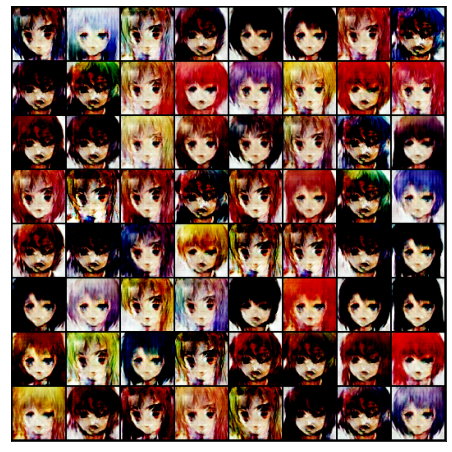

In [45]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

save_samples(28,fixed_latent)